In [1]:
import sys
sys.path.append("/home/j-gunmo/desktop/00.my-project/17.P-Stage-T1003/4-STAGE/")

from fe.feature import FEBase

from fe.agg import (
    MakeCorrectCount, 
    MakeCorrectPercent, 
    MakeQuestionCount, 
    MakeTopNCorrectPercent
)

from fe.seq import (
    SplitAssessmentItemID,
    MakeFirstClass,
    MakeSecondClass,
    MakeTimeDiff,
    MakeYMD,
    ConvertTime
)

from dkt_dataset import Preprocess
from utils import get_args, get_root_dir
from fe.feature import FEPipeline
import easydict
from IPython.display import clear_output

In [2]:
args = get_args()
args.data_dir = "../../input/data/train_dataset/"

In [3]:
args.root_dir = get_root_dir("../feature_test/")

In [4]:
import os.path as p
import pandas as pd
df = pd.read_csv(p.join(args.data_dir, "train_data.csv"))

# Prepare

In [5]:
args.num_workers = 2
args.n_epochs = 10
args.hidden_dim = 512
args.use_dynamic = True

In [6]:
args

{'seed': 42,
 'device': 'cuda',
 'use_dynamic': True,
 'max_seq_len': 20,
 'num_workers': 2,
 'data_dir': '../../input/data/train_dataset/',
 'hidden_dim': 512,
 'n_layers': 2,
 'dropout': 0.2,
 'n_epochs': 10,
 'batch_size': 64,
 'lr': 0.0001,
 'clip_grad': 10,
 'log_steps': 50,
 'patience': 5,
 'loss': 'bce_loss',
 'loss_hp': {'reduction': 'none'},
 'optimizer': 'adam',
 'optimizer_hp': {'lr': 0.0001, 'weight_decay': 0.01},
 'scheduler': 'plateau',
 'scheduler_hp': {'patience': 10,
  'factor': 0.5,
  'mode': 'max',
  'verbose': True},
 'root_dir': '../feature_test/'}

In [7]:
import torch
from trainer import DKTTrainer
from models.lstm.model import LSTM

class FeatureTestTrainer(DKTTrainer):
    def _process_batch(self, batch):
        batch['mask'] = batch['mask'].type(torch.FloatTensor)
        batch["answerCode"] = batch["answerCode"].type(torch.FloatTensor)

        batch["interaction"] = batch["answerCode"] + 1
        batch["interaction"] = batch["interaction"].roll(shifts=1, dims=1)
        batch["mask"] = batch["mask"].roll(shifts=1, dims=1)
        batch["mask"][:, 0] = 0
        batch["interaction"] = (batch["interaction"] * batch["mask"]).to(torch.int64)
        
        
        for k in self.args.n_linears: # 수치형
            batch[k] = batch[k].type(torch.FloatTensor)
            
        for k, v in self.args.n_embeddings.items(): # 범주형
            batch[k] = batch[k].to(torch.int64)
            
        for k in batch.keys():
            batch[k] = batch[k].to(self.args.device)
        
        return batch

In [8]:
def test_pipeline(args, feature=[], column_name=[], pre_enc=dict()):
    fe_list = [
        SplitAssessmentItemID,
        ConvertTime,
        MakeFirstClass,
        MakeSecondClass,
        MakeCorrectCount,
        MakeQuestionCount,
        MakeCorrectPercent
    ] + feature
    
    fe_pipeline = FEPipeline(
        args, fe_list
    )
    
    columns = [
        "userID",
        "answerCode",
        "testPaper",
        "timeSec",
        "firstClass",
        "secondClass",
        "correctPer"
    ] + column_name
    
    pre_encoders = {
        "label": ["testPaper", "firstClass", "secondClass"],
        "min_max": ["correctPer"],
        "std": ["timeSec"],
    }
    
    for k in pre_enc.keys():
        pre_encoders[k] += pre_enc[k]

    preprocess = Preprocess(args, fe_pipeline, columns)

    preprocess.feature_engineering() # feature 
    preprocess.split_data() # train => train, valid
    preprocess.scaling(pre_encoders) # vector로 바꿔주고 Scaling해주고
    preprocess.data_augmentation(choices=[1, 3]) # [1, 2] 1: test_data추가, 2: user_id 기준 group_by 
    # 3: user_id, test_paer group_by

    train_dataset = preprocess.get_data("train_grouped")
    valid_dataset = preprocess.get_data("valid_grouped")
    test_dataset = preprocess.get_data("test_grouped")

    args.columns = columns[1:]
    
    trainer = FeatureTestTrainer(args, LSTM)
    return trainer, train_dataset, valid_dataset, test_dataset, preprocess

def log_notebook_fold5(trainer, train_data, valid_data, test_data):
    auc, acc = trainer.run_cv(train_data, valid_data, test_data, 
                              folds=5, seeds=[0, 1, 2, 3, 4])
    clear_output()
    print(f"auc: {auc}, acc: {acc}")

# Base Feature CV Score
- testPaper : 시험지 번호
- firstClass : 대분류 ( 1 ~ 9 )
- secondClass : 중분류 ( KnowledgeTag )
- correctPer : 전체 문항에 대한 정답률
- timeSec : 사용자가 문제를 푼 시간 정보입니다.

# Dynamic DKTDataset Test

- SequenceFeature 영향을 받으려면 마지막 Sequence말고 중간 Sequence도 뽑아야 할 것 같아서..

## Dynamic 적용 전

In [11]:
trainer, train_data, valid_data, test_data, preprocess = test_pipeline(args)
log_notebook_fold5(trainer, train_data, valid_data, test_data)

auc: 0.7605497004766788, acc: 0.6969604863221884


## Dynamic 적용 후

In [8]:
args.use_dynamic

True

In [9]:
trainer, train_data, valid_data, test_data, preprocess = test_pipeline(args)
log_notebook_fold5(trainer, train_data, valid_data, test_data)

auc: 0.7672647713883387, acc: 0.7218844984802433


## Dynamic 적용 후 + epochs 20

In [158]:
args.n_epochs = 20

In [159]:
trainer, train_data, valid_data, test_data, preprocess = test_pipeline(args)
log_notebook_fold5(trainer, train_data, valid_data, test_data)

auc: 0.767276291572018, acc: 0.7231003039513679


# Seed Test

3번의 결과값이 같게 나오는지를 봐서 시드 고정을 체크한다.

## Dynamic 적용 전

In [52]:
trainer, train_data, valid_data, test_data, preprocess = test_pipeline(args)
log_notebook_fold5(trainer, train_data, valid_data, test_data)

auc: 0.7662840384422888, acc: 0.7018743667679839


In [53]:
trainer, train_data, valid_data, test_data, preprocess = test_pipeline(args)
log_notebook_fold5(trainer, train_data, valid_data, test_data)

auc: 0.7662840384422888, acc: 0.7018743667679839


In [54]:
trainer, train_data, valid_data, test_data, preprocess = test_pipeline(args)
log_notebook_fold5(trainer, train_data, valid_data, test_data)

auc: 0.7662840384422888, acc: 0.7018743667679839


In [17]:
import os.path as p
import pandas as pd
from fe.seq import SeqFeBase
from fe.agg import AggFeBase
import seaborn as sns
import matplotlib.pyplot as plt

train_dataset = pd.read_csv(p.join(args.data_dir, "train_data.csv"))

In [56]:
vi_df = preprocess.get_data("train")

In [20]:
ne_df = ConvertTime._transform(train_dataset)

In [21]:
ne_df - ne_df.shift(1)

,timeSec
0,NaN
1,3.0
2,8.0
3,7.0
4,7.0
...,...
2266581,24.0
2266582,6632178.0
2266583,11.0
2266584,46.0


## TimeDiff

사용자가 한 문제를 푸는데 걸린 시간

In [22]:
from fe.seq import SeqFeBase

class MakeTimeDiff(SeqFeBase):
    name = "make_time_diff"
    description = {"timeDiff": "사용자가 한 문제를 푸는데 걸린 시간입니다."}
    pre_fe = {"split_assessmentitem_id", "convert_time"}
    
    @classmethod
    def _transform(cls, df):
        new_df = pd.DataFrame()
        new_df['timeDiff'] = df.groupby(["userID", "testPaper"]).timeSec.apply(lambda x: x - x.shift(1, fill_value=list(x)[0]))
        new_df['timeDiff'] = new_df['timeDiff'].apply(lambda x: x if x < 200 else 200)  # quantile: 0.95
        # 0.95 == 224, 이상치 데이터는 200으로
        return new_df

In [59]:
vi_df.head(3)

,userID,answerCode,testPaper,timeSec,firstClass,secondClass,correctPer,timeDiff
0,0,1,975,-1.432905,5,618,0.630872,0.000000e+00
1,0,1,975,-1.432904,5,619,0.630872,1.045446e-07
2,0,1,975,-1.432903,5,619,0.630872,2.787857e-07


### Dynamic 적용 전

In [52]:
args.use_dynamic = False

In [53]:
# min_max, std
fe = [MakeTimeDiff]
cn = ["timeDiff"]
pre_e = {
    "min_max" : ["timeDiff"]
}

trainer, train_data, valid_data, test_data, preprocess = test_pipeline(args, fe, cn, pre_e)
log_notebook_fold5(trainer, train_data, valid_data, test_data)

auc: 0.7659187855940672, acc: 0.7022796352583587


In [26]:
fe = [MakeTimeDiff]
cn = ["timeDiff"]
pre_e = {
    "std" : ["timeDiff"]
}

trainer, train_data, valid_data, test_data, preprocess = test_pipeline(args, fe, cn, pre_e)
log_notebook_fold5(trainer, train_data, valid_data, test_data)

auc: 0.7658911101756501, acc: 0.7022796352583587


### Dynamic 적용 후

In [61]:
args.use_dynamic = True

In [62]:
fe = [MakeTimeDiff]
cn = ["timeDiff"]
pre_e = {
    "min_max" : ["timeDiff"]
}

trainer, train_data, valid_data, test_data, preprocess = test_pipeline(args, fe, cn, pre_e)
log_notebook_fold5(trainer, train_data, valid_data, test_data)

auc: 0.7665029770728836, acc: 0.7204660587639312


In [30]:
fe = [MakeTimeDiff]
cn = ["timeDiff"]
pre_e = {
    "std" : ["timeDiff"]
}

trainer, train_data, valid_data, test_data, preprocess = test_pipeline(args, fe, cn, pre_e)
log_notebook_fold5(trainer, train_data, valid_data, test_data)

auc: 0.7665893949570677, acc: 0.7205167173252279


## UserCurNAccuracy

사용자가 최근 푼 N개의 정답률

In [31]:
class MakeUserCurAccuracy(SeqFeBase):
    name = "make_user_cur_accuracy"
    description = {
        "userCur10Accuracy": "사용자의 최근 푼 10개 문항의 정답률을 나타냅니다.",
        "userCur20Accuracy": "사용자의 최근 푼 20개 문항의 정답률을 나타냅니다.",
        "userCur30Accuracy": "사용자의 최근 푼 30개 문항의 정답률을 나타냅니다.",
        "userCur40Accuracy": "사용자의 최근 푼 40개 문항의 정답률을 나타냅니다."
    }
    
    @classmethod
    def _transform(cls, df):
        new_df = pd.DataFrame()
        new_df['userCur10Accuracy'] = df['answerCode'].rolling(window=10, min_periods=1).mean()
        new_df['userCur20Accuracy'] = df['answerCode'].rolling(window=20, min_periods=1).mean()
        new_df['userCur30Accuracy'] = df['answerCode'].rolling(window=30, min_periods=1).mean()
        new_df['userCur40Accuracy'] = df['answerCode'].rolling(window=40, min_periods=1).mean()
        return new_df

In [73]:
fe = [MakeUserCurAccuracy]
cn = ["userCur10Accuracy"]
pre_e = {
    "min_max" : ["userCur10Accuracy"]
}

trainer, train_data, valid_data, test_data, preprocess = test_pipeline(args, fe, cn, pre_e)
log_notebook_fold5(trainer, train_data, valid_data, test_data)

auc: 0.7675818746349291, acc: 0.7017223910840933


In [74]:
fe = [MakeUserCurAccuracy]
cn = ["userCur20Accuracy"]
pre_e = {
    "min_max" : ["userCur20Accuracy"]
}

trainer, train_data, valid_data, test_data, preprocess = test_pipeline(args, fe, cn, pre_e)
log_notebook_fold5(trainer, train_data, valid_data, test_data)

auc: 0.7666365511513533, acc: 0.7015704154002027


In [75]:
fe = [MakeUserCurAccuracy]
cn = ["userCur30Accuracy"]
pre_e = {
    "min_max" : ["userCur30Accuracy"]
}

trainer, train_data, valid_data, test_data, preprocess = test_pipeline(args, fe, cn, pre_e)
log_notebook_fold5(trainer, train_data, valid_data, test_data)

auc: 0.7665253725938547, acc: 0.7023809523809523


In [76]:
fe = [MakeUserCurAccuracy]
cn = ["userCur40Accuracy"]
pre_e = {
    "min_max" : ["userCur40Accuracy"]
}

trainer, train_data, valid_data, test_data, preprocess = test_pipeline(args, fe, cn, pre_e)
log_notebook_fold5(trainer, train_data, valid_data, test_data)

auc: 0.7665131375039842, acc: 0.7034447821681864


## TODOLIST

- [x] 문제별 난이도 특성 추가
- [x] 지금까지 풀어온 대분류별 정답률 특성 추가 ( 현재 문제 대분류의 정답률로만...! )
    - 대분류가 9라면 지금까지 풀어온 9라는 대분류의 정답률 추가
    - 만약 지금까지 정보가 없다면 현재까지의 정답률, 또는 0.5의 값
    - 대분류 특성은 이미 있으므로 패스
- [x] 각 문제 종류별로 이전에 몇번 풀었는지
- 태그 간에 규칙이 있는지 체크해보기...
    - 이전에 시험지에 등장하는 최대 태그가 한 3개가 있다고 그랬던 것 같은데
    - Matrix 만들어볼까...? 시험지하고 태그, 대분류하고 태그..?

## 문제별 난이도 특성

문제의 전체 정답률(난이도)을 나타냅니다.

In [32]:
from fe.agg import AggFeBase

class MakeDifficultyByAssessmentItem(AggFeBase):
    name = "make_difficulty_by_assessmentitem_id"
    description = {
        "problemDifficulty" : "문제의 전체 정답률(난이도)을 나타냅니다."
    }
    agg_column = ["assessmentItemID"]
    
    @classmethod
    def _transform(cls, df):
        grouped_df = df.groupby(cls.agg_column).answerCode.mean()
        right_df = pd.DataFrame({"assessmentItemID" : grouped_df.index, "problemDifficulty": list(grouped_df)})
        return right_df

<AxesSubplot:xlabel='assessmentItemID'>

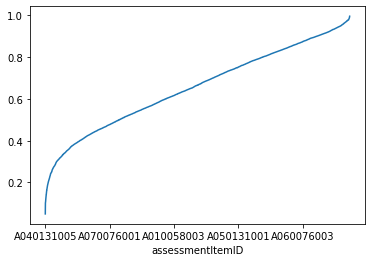

In [25]:
temp.sort_values().plot()

In [33]:
fe = [MakeDifficultyByAssessmentItem]
cn = ["problemDifficulty"]
pre_e = {
    "min_max" : ["problemDifficulty"]
}

trainer, train_data, valid_data, test_data, preprocess = test_pipeline(args, fe, cn, pre_e)
log_notebook_fold5(trainer, train_data, valid_data, test_data)

auc: 0.7683197274447398, acc: 0.7224924012158056


In [34]:
fe = [MakeDifficultyByAssessmentItem]
cn = ["problemDifficulty"]
pre_e = {
    "std" : ["problemDifficulty"]
}

trainer, train_data, valid_data, test_data, preprocess = test_pipeline(args, fe, cn, pre_e)
log_notebook_fold5(trainer, train_data, valid_data, test_data)

auc: 0.7768259920069956, acc: 0.7268996960486322


In [40]:
MakeFirstClass._transform(df)

,firstClass
0,6
1,6
2,6
3,6
4,6
...,...
2266581,3
2266582,4
2266583,4
2266584,4


## 대분류별 정답률 특성 추가

- 유저의 대분류별 정답률을 나타냅니다.

In [10]:
from fe.agg import AggFeBase

class MakeDifficultyByFirstClass(AggFeBase):
    name = "make_difficulty_by_firstclass"
    description = {
        "firstClassDifficulty" : "유저의 대분류별 정답률을 나타냅니다."
    }
    
    pre_fe = {"make_first_class"}
    agg_column = ["userID", "firstClass"]
    
    @classmethod
    def _transform(cls, df):
        grouped_df = df.groupby(cls.agg_column).answerCode.mean()
        a, b = zip(*grouped_df.index)
        
        right_df = pd.DataFrame(
            {"userID": a, "firstClass": b, "firstClassDifficulty": list(grouped_df)}
        )
        
        return right_df

In [18]:
fe = [MakeDifficultyByFirstClass]
cn = ["firstClassDifficulty"]
pre_e = {
    "min_max" : ["firstClassDifficulty"]
}

trainer, train_data, valid_data, test_data, preprocess = test_pipeline(args, fe, cn, pre_e)
log_notebook_fold5(trainer, train_data, valid_data, test_data)

auc: 0.7810246989556201, acc: 0.7034954407294831


In [16]:
fe = [MakeDifficultyByFirstClass]
cn = ["firstClassDifficulty"]
pre_e = {
    "std" : ["firstClassDifficulty"]
}

trainer, train_data, valid_data, test_data, preprocess = test_pipeline(args, fe, cn, pre_e)
log_notebook_fold5(trainer, train_data, valid_data, test_data)

auc: 0.7838349380100875, acc: 0.6931104356636272


### args.use_dynamic = False 로 CV Score, LB Score 비교

In [12]:
args.use_dynamic = False

In [13]:
fe = [MakeDifficultyByFirstClass]
cn = ["firstClassDifficulty"]
pre_e = {
    "std" : ["firstClassDifficulty"]
}

trainer, train_data, valid_data, test_data, preprocess = test_pipeline(args, fe, cn, pre_e)
log_notebook_fold5(trainer, train_data, valid_data, test_data)
print(f"logging path: {trainer.prefix_save_path}")

auc: 0.7958974961259273, acc: 0.7222391084093213
logging path: ../feature_test/LOG_[06.11_15:05]


**LB AUC: 0.7394 LB ACC : 0.6989**

In [15]:
args.use_dynamic = True
fe = [MakeDifficultyByFirstClass]
cn = ["firstClassDifficulty"]
pre_e = {
    "std" : ["firstClassDifficulty"]
}

trainer, train_data, valid_data, test_data, preprocess = test_pipeline(args, fe, cn, pre_e)
log_notebook_fold5(trainer, train_data, valid_data, test_data)
print(f"logging path: {trainer.prefix_save_path}")

auc: 0.7884153577405428, acc: 0.6969098277608916
logging path: ../feature_test/LOG_[06.11_15:31]


## 지금까지 풀어온 대분류별 정답률 특성 추가

- 유저가 푸는 문제의 대분류의 현재까지의 정답률을 나타냅니다.
- 처음 정답률은 0.5로 설정
- 대분류가 연속적으로 등장해서... 중분류를 좀 더 확장시키는 특성이 더 있으면 좋을 것 같다.

In [47]:
from fe.seq import SeqFeBase

class MakeDifficultyByCurFirstClass(SeqFeBase):
    name = "make_difficulty_by_cur_firstclass"
    description = {
        "curFCDifficulty" : "유저가 지금까지 풀어왔던 문제의 대분류의 정답률을 나타냅니다",
        "curFCMADifficulty" : "유저가 지금까지 풀어왔던 문제의 대분류의 이동 평균 정답률을 나타냅니다"
    }
    pre_fe = {"make_first_class", "split_assessmentitem_id"}
        
    @classmethod
    def _transform(cls, df):
        """ 반복문 돌면 1분 35초 걸린다... """
        new_df = pd.DataFrame()
        grouped_df = df.groupby(["userID", "firstClass"])
        new_df["cum_sum"] = grouped_df.answerCode.apply(lambda x: x.cumsum())
        new_df["cum_count"] = grouped_df.answerCode.cumcount() + 1
        
        new_df["userID"] = df["userID"]
        new_df["firstClass"] = df["firstClass"]
        new_df["cum_per"] = new_df["cum_sum"] / (new_df["cum_count"])
        
        grouped_df = new_df.groupby(["userID", "firstClass"])
        
        new_df["curFCDifficulty"] = grouped_df.cum_per.shift(1)
        new_df["curFCDifficulty"].fillna(0.5, inplace=True)  # 처음 정답률은 0.5, 맞출지 못맞출지 모르니깐
        
        grouped_df = new_df.groupby(["userID", "firstClass"])
        
        new_df["curFCMADifficulty"] = list(grouped_df.curFCDifficulty.apply(lambda x: x.rolling(window=10, min_periods=1).mean()))
        
        return new_df[["curFCDifficulty", "curFCMADifficulty"]]

<AxesSubplot:>

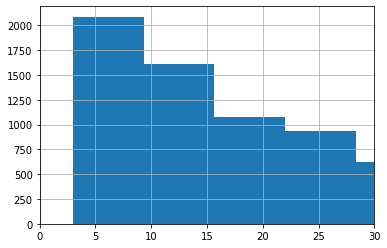

In [268]:
plt.xlim([0, 30])
grouped_df.count().testId.hist(bins=200)

In [48]:
fe = [MakeDifficultyByCurFirstClass]
cn = ["curFCDifficulty"]
pre_e = {
    "std" : ["curFCDifficulty"]
}

trainer, train_data, valid_data, test_data, preprocess = test_pipeline(args, fe, cn, pre_e)
log_notebook_fold5(trainer, train_data, valid_data, test_data)

auc: 0.7694437226674198, acc: 0.72193515704154


In [49]:
fe = [MakeDifficultyByCurFirstClass]
cn = ["curFCDifficulty"]
pre_e = {
    "min_max" : ["curFCDifficulty"]
}

trainer, train_data, valid_data, test_data, preprocess = test_pipeline(args, fe, cn, pre_e)
log_notebook_fold5(trainer, train_data, valid_data, test_data)

auc: 0.7692124629526644, acc: 0.7196048632218845


In [50]:
fe = [MakeDifficultyByCurFirstClass]
cn = ["curFCMADifficulty"]
pre_e = {
    "std" : ["curFCMADifficulty"]
}

trainer, train_data, valid_data, test_data, preprocess = test_pipeline(args, fe, cn, pre_e)
log_notebook_fold5(trainer, train_data, valid_data, test_data)

auc: 0.7699093338388746, acc: 0.72370820668693


In [51]:
fe = [MakeDifficultyByCurFirstClass]
cn = ["curFCMADifficulty"]
pre_e = {
    "min_max" : ["curFCMADifficulty"]
}

trainer, train_data, valid_data, test_data, preprocess = test_pipeline(args, fe, cn, pre_e)
log_notebook_fold5(trainer, train_data, valid_data, test_data)

auc: 0.7695624123608785, acc: 0.719756838905775


## 각 문제 종류별로 이전에 몇번 풀었는지 특성 추가

- 좀 직접적인 특성이다.
- 생각해보니깐 대분류가 연속으로 등장해서 큰 의미가 없을 것 같다...

## 순서 바꿔서 성능 테스트 해보기

### Qcut

- Qcut 현재 문제가 있어서 Cut으로 바꿈
- 지금 PR은 Cut으로 공유할 코드
- Cut도 잘 나온다.
    - 비슷한 성능이 나오는데
    - 600기준, 1초 기준으로 짜른다.
    - BatchSize를 낮춰서 돌리고 제출해봤는데 8181 나왔다.